In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
# if cuda is available, use it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data

## split data into train and validation

In [3]:
# Load the data
data = pd.read_csv('train-minst.csv')
# data = pd.read_csv('test-minst.csv') # only for architecture building
label = data['label'].values
data = data.values[:, 1:]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, label, test_size=0.2, random_state=42)

data_for_CNN = data.reshape(data.shape[0], 28, 28)

## k-fold cross validation

1. 减少过拟合的风险，因为模型在多个数据子集上进行了训练和验证
2. 提供更可靠的性能估计，因为它考虑了数据集中的变异性
3. 计算成本较高，特别是对于大数据集或复杂的模型
4. 对于时间序列数据，如果数据点之间的顺序很重要，标准的交叉验证方法可能不适用

In [4]:
# k-fold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# for train_index, val_index in kf.split(data):
#     X_train_kfold, X_val_kfold = data[train_index], data[val_index]
#     y_train_kfold, y_val_kfold = label[train_index], label[val_index]
#     break

## data features

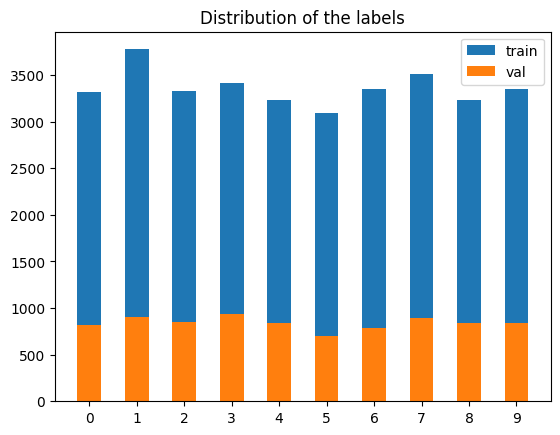

In [5]:
# distribution of the labels
# show the xlabel 1 to 0
plt.xticks(range(11))
plt.hist(y_train, label='train', rwidth=0.5, align='left',bins=range(11))
plt.hist(y_val, label='val', rwidth=0.5, align='left',bins=range(11))
plt.title('Distribution of the labels')
plt.legend()
plt.show()

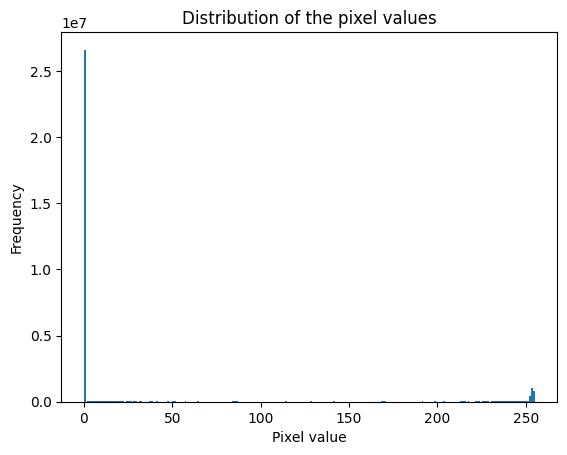

In [33]:
x= data.reshape(-1)
plt.hist(x, bins=range(256))
plt.title('Distribution of the pixel values')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()

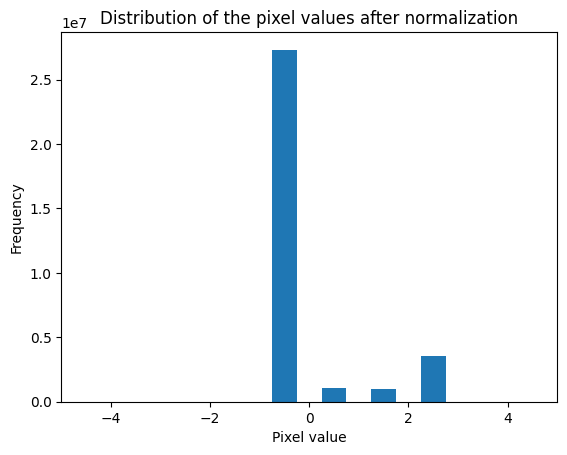

In [34]:
x = (x-np.mean(x))/np.std(x)
plt.hist(x, bins=range(-5, 6), rwidth=0.5)
plt.xlim(-5, 5)
plt.title('Distribution of the pixel values after normalization')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()

## data Normalization

In [18]:
# 归一化
# X_train = X_train/255.0
# X_val = X_val/255.0

# CNN归一化
data_for_CNN = data_for_CNN/255.0

## PCA降维数据

In [19]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_val_PCA = pca.transform(X_val)

## data show

Text(0.5, 1.0, 'Label: 1')

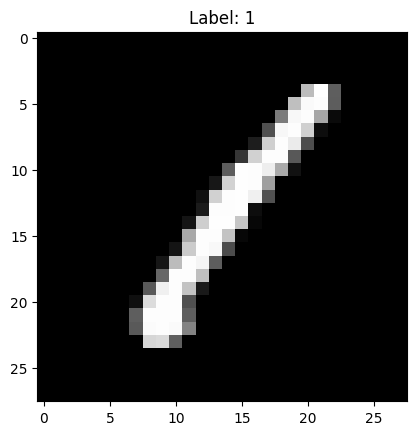

In [6]:
# data show
plt.imshow(data_for_CNN[0], cmap='gray')
plt.title('Label: {}'.format(label[0]))

Text(0.5, 1.0, 'Label: 0')

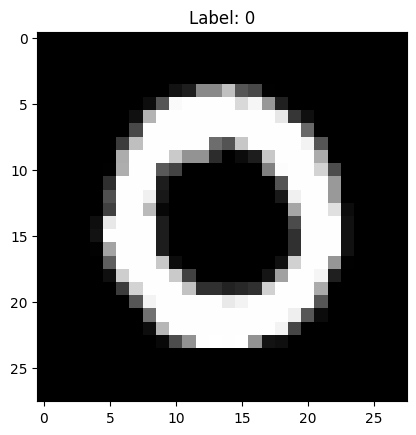

In [8]:
plt.imshow(data_for_CNN[1], cmap='gray')
plt.title('Label: {}'.format(label[1]))

Text(0.5, 1.0, 'Label: 8')

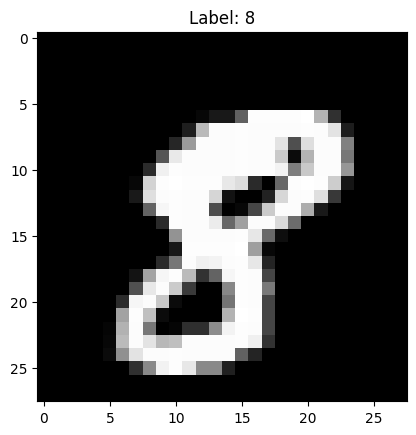

In [9]:
plt.imshow(data_for_CNN[10], cmap='gray')
plt.title('Label: {}'.format(label[10]))

# Feedforward Neural Network

In [12]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(784, 10)
    def forward(self, x):
        return self.linear(x)

In [ ]:
Net = LinearModel().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.01)

accuracy_list = []
loss_list = []
data_forLinear = torch.tensor(data, dtype=torch.float32).to(device)
label_forLinear = torch.tensor(label, dtype=torch.long).to(device)

for epoch in range(500):
    acc =[]
    for train_index, val_index in kf.split(data_forLinear):
        X_train_kfold, X_val_kfold = data_forLinear[train_index], data_forLinear[val_index]
        y_train_kfold, y_val_kfold = label_forLinear[train_index], label_forLinear[val_index]
        optimizer.zero_grad()
        outputs = Net(X_train_kfold)
        loss = criterion(outputs, y_train_kfold)
        loss.backward()
        optimizer.step()
        acc.append((Net(X_val_kfold).argmax(1) == y_val_kfold).float().mean().item())
    accuracy_list.append(np.mean(acc))
    loss_list.append(loss.item())
    print('Epoch: {}, Loss: {}, Accuracy: {}'.format(epoch, loss.item(), np.mean(acc)))


/tmp/ipykernel_371274/1521505310.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)
/tmp/ipykernel_371274/1521505310.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long).to(device)


Epoch: 0, Loss: 87.01345825195312, Accuracy: 0.39795238673686983
Epoch: 1, Loss: 32.212440490722656, Accuracy: 0.6785237908363342
Epoch: 2, Loss: 24.982309341430664, Accuracy: 0.7970714211463928
Epoch: 3, Loss: 19.773717880249023, Accuracy: 0.8463571429252624
Epoch: 4, Loss: 18.42112922668457, Accuracy: 0.8691904664039611
Epoch: 5, Loss: 14.087121963500977, Accuracy: 0.8899285674095154
Epoch: 6, Loss: 13.79685115814209, Accuracy: 0.8923571348190308
Epoch: 7, Loss: 11.446094512939453, Accuracy: 0.9037618994712829
Epoch: 8, Loss: 10.504827499389648, Accuracy: 0.9081190466880799
Epoch: 9, Loss: 9.483168601989746, Accuracy: 0.9107142806053161
Epoch: 10, Loss: 8.5773286819458, Accuracy: 0.9126190423965455
Epoch: 11, Loss: 7.711748123168945, Accuracy: 0.9149999737739563
Epoch: 12, Loss: 7.072245121002197, Accuracy: 0.9175952196121215
Epoch: 13, Loss: 6.49940824508667, Accuracy: 0.9200238108634948
Epoch: 14, Loss: 5.988988876342773, Accuracy: 0.9204523801803589
Epoch: 15, Loss: 5.546319961547

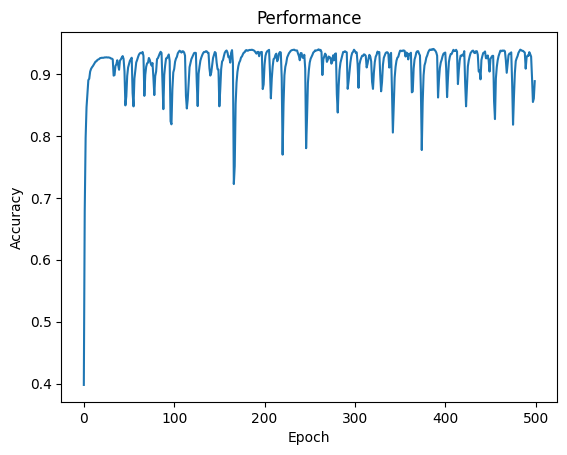

In [28]:
plt.plot(accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Performance')
plt.show()

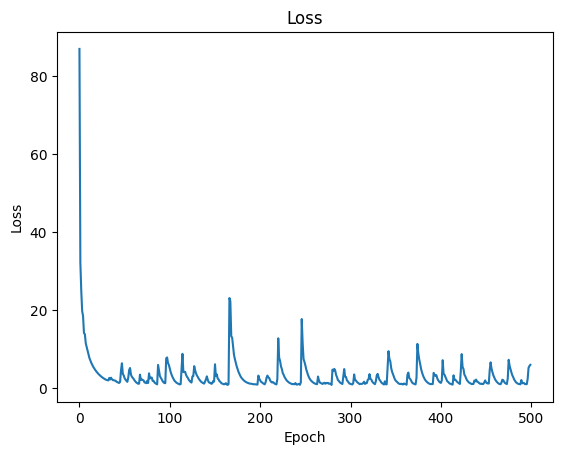

In [27]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

# CNN Model

## super parameter (n_layer, stoppinh criteria, con_kernal)

## Loss function

## Model

In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32*7*7, 128)
        self.fc2 = torch.nn.Linear(128, 10)
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 32*7*7)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
Net = CNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Net.parameters(), lr=0.001)##TODO choose different optimizer

In [6]:
data_for_CNN = torch.tensor(data_for_CNN,dtype=torch.float32).view(-1, 1, 28, 28).to(device)

In [7]:
# move the model to GPU
Net.to(device)

performance = []
losslist = []
for epoch in range(50):
    acc = []
    for train_index, val_index in kf.split(data_for_CNN):
        X_train_kfold, X_val_kfold = data_for_CNN[train_index], data_for_CNN[val_index]
        y_train_kfold, y_val_kfold = torch.tensor(label[train_index]).to(device), torch.tensor(label[val_index]).to(device)

        optimizer.zero_grad()
        output = Net(X_train_kfold)
        loss = criterion(output, y_train_kfold)
        loss.backward()
        optimizer.step()

        output = Net(X_val_kfold)
        _, predicted = torch.max(output, 1)
        acc.append((predicted == y_val_kfold).sum().item()/y_val_kfold.size(0))

    performance.append(np.mean(acc))
    losslist.append(loss.item())
    print('epoch {}, accuracy {}, loss{}'.format(epoch, performance[-1], loss.item()))

epoch 0, accuracy 0.2695714285714286, loss10.734796524047852
epoch 1, accuracy 0.43000000000000005, loss4.217251300811768
epoch 2, accuracy 0.5248095238095238, loss1.8972773551940918
epoch 3, accuracy 0.6316190476190476, loss1.3337225914001465
epoch 4, accuracy 0.7136904761904762, loss1.0094112157821655
epoch 5, accuracy 0.7777857142857143, loss0.681894063949585
epoch 6, accuracy 0.8458333333333334, loss0.47315526008605957
epoch 7, accuracy 0.9073809523809524, loss0.2948238253593445
epoch 8, accuracy 0.9252619047619047, loss0.23635505139827728
epoch 9, accuracy 0.9417619047619048, loss0.1820395588874817
epoch 10, accuracy 0.9517857142857142, loss0.15264976024627686
epoch 11, accuracy 0.9595476190476189, loss0.12792177498340607
epoch 12, accuracy 0.9654761904761905, loss0.10940368473529816
epoch 13, accuracy 0.9693333333333334, loss0.09513584524393082
epoch 14, accuracy 0.9723571428571429, loss0.08407111465930939
epoch 15, accuracy 0.9759047619047619, loss0.0754222571849823
epoch 16, ac

In [ ]:
# Save the model
# torch.save(Net.state_dict(), 'model.pth')

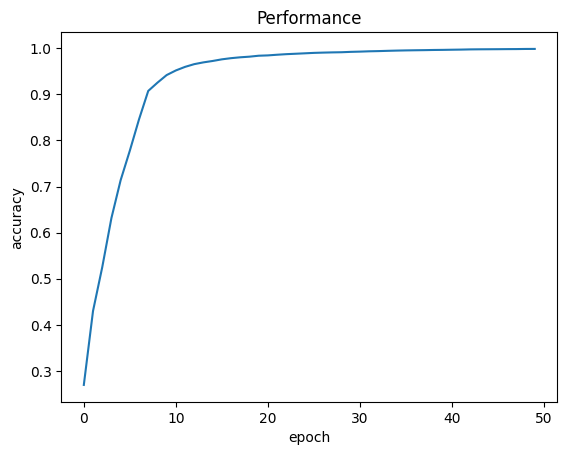

In [8]:
plt.plot(performance)
plt.title('Performance')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()


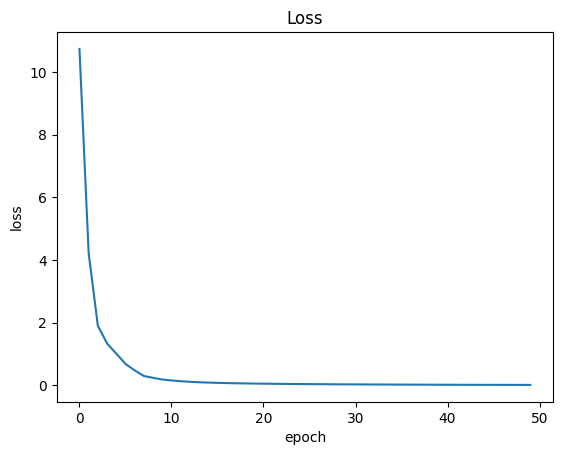

In [9]:
plt.plot(losslist)
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
Net = CNN()
Net.load_state_dict(torch.load('model.pth'))

# Test the model
data = pd.read_csv('train-minst.csv')
data = data.values[:, 1:]/255
data = data.reshape(data.shape[0], 28, 28)
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)

output = Net(data)
output = torch.argmax(output, dim=1)
output = output.numpy()

/tmp/ipykernel_371274/841259517.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Net.load_state_dict(torch.load('model.pth'))


In [11]:
data = pd.read_csv('train-minst.csv')
data = data.values[:, 0]
# 合并两个数组
data = np.vstack((data, output))
pd.DataFrame(data.T, columns=['ImageId', 'Label']).to_csv('comp.csv', index=False)
Accuracy = np.sum(data[0] == data[1])/data.shape[1]
print('Accuracy:', Accuracy)

Accuracy: 0.9999761904761905


# KNN

In [4]:
# KNN
accuracy = []
timelist_beforeNorm = []
from sklearn.neighbors import KNeighborsClassifier
for i in range(1, 40):
    time_start = time.time()
    temp = []
    for train_index, val_index in kf.split(data):
        X_train_kfold, X_val_kfold = data[train_index], data[val_index]
        y_train_kfold, y_val_kfold = label[train_index], label[val_index]
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train_kfold, y_train_kfold)
        y_pred = knn.predict(X_val_kfold)
        Accuracy = np.sum(y_pred == y_val_kfold)/y_val_kfold.shape[0]
        temp.append(Accuracy)
    accuracy.append(np.mean(temp))
    print('n_neighbors: {}, accuracy: {}'.format(i, accuracy[-1]))
    time_end = time.time()
    timelist_beforeNorm.append(time_end-time_start)

n_neighbors: 1, accuracy: 0.9669285714285714
n_neighbors: 2, accuracy: 0.9607142857142857
n_neighbors: 3, accuracy: 0.9673333333333332
n_neighbors: 4, accuracy: 0.9662380952380953
n_neighbors: 5, accuracy: 0.9665714285714285
n_neighbors: 6, accuracy: 0.964952380952381
n_neighbors: 7, accuracy: 0.9648809523809524
n_neighbors: 8, accuracy: 0.9638809523809524
n_neighbors: 9, accuracy: 0.9632142857142858
n_neighbors: 10, accuracy: 0.9625
n_neighbors: 11, accuracy: 0.9622142857142858
n_neighbors: 12, accuracy: 0.9614761904761904
n_neighbors: 13, accuracy: 0.9606190476190477
n_neighbors: 14, accuracy: 0.9601190476190476
n_neighbors: 15, accuracy: 0.9591904761904761
n_neighbors: 16, accuracy: 0.9588333333333333
n_neighbors: 17, accuracy: 0.957952380952381
n_neighbors: 18, accuracy: 0.957452380952381
n_neighbors: 19, accuracy: 0.9565952380952382
n_neighbors: 20, accuracy: 0.9558809523809524
n_neighbors: 21, accuracy: 0.9550476190476189
n_neighbors: 22, accuracy: 0.9546428571428571
n_neighbors:

In [ ]:
# 归一化
# 方法一
X_train_norm = (X_train-X_train.mean(axis=0))/X_train.std(axis=0)
X_val_norm = (X_val-X_val.mean(axis=0))/X_val.std(axis=0)
X_train_norm = np.nan_to_num(X_train_norm)
X_val_norm = np.nan_to_num(X_val_norm)

# 方法二
# X_train_norm = X_train/255.0
# X_val_norm = X_val/255.0

/tmp/ipykernel_374309/2210648166.py:3: RuntimeWarning: invalid value encountered in divide
  X_train_norm = (X_train-X_train.mean(axis=0))/X_train.std(axis=0)
/tmp/ipykernel_374309/2210648166.py:4: RuntimeWarning: invalid value encountered in divide
  X_val_norm = (X_val-X_val.mean(axis=0))/X_val.std(axis=0)


In [6]:
# 归一化后的KNN
accuracy = []
timelist_afterNorm = []
from sklearn.neighbors import KNeighborsClassifier
for i in range(1, 40):
    time_start = time.time()
    temp = []
    for train_index, val_index in kf.split(X_train_norm):
        X_train_kfold, X_val_kfold = X_train_norm[train_index], X_train_norm[val_index]
        y_train_kfold, y_val_kfold = y_train[train_index], y_train[val_index]
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train_kfold, y_train_kfold)
        y_pred = knn.predict(X_val_kfold)
        Accuracy = np.sum(y_pred == y_val_kfold)/y_val_kfold.shape[0]
        temp.append(Accuracy)
    accuracy.append(np.mean(temp))
    print('n_neighbors: {}, accuracy: {}'.format(i, accuracy[-1]))
    time_end = time.time()
    timelist_afterNorm.append(time_end-time_start)

n_neighbors: 1, accuracy: 0.9324107142857143


n_neighbors: 2, accuracy: 0.9223809523809523
n_neighbors: 3, accuracy: 0.9348809523809523
n_neighbors: 4, accuracy: 0.9322321428571427
n_neighbors: 5, accuracy: 0.934077380952381
n_neighbors: 6, accuracy: 0.9309821428571429
n_neighbors: 7, accuracy: 0.9316071428571429
n_neighbors: 8, accuracy: 0.9304166666666667
n_neighbors: 9, accuracy: 0.9302083333333334
n_neighbors: 10, accuracy: 0.9285714285714286
n_neighbors: 11, accuracy: 0.9283928571428571
n_neighbors: 12, accuracy: 0.9268749999999999
n_neighbors: 13, accuracy: 0.9261011904761904
n_neighbors: 14, accuracy: 0.925297619047619
n_neighbors: 15, accuracy: 0.9247321428571429
n_neighbors: 16, accuracy: 0.9228869047619046
n_neighbors: 17, accuracy: 0.9232738095238096
n_neighbors: 18, accuracy: 0.9217559523809523
n_neighbors: 19, accuracy: 0.9217857142857143
n_neighbors: 20, accuracy: 0.9198511904761905
n_neighbors: 21, accuracy: 0.9195535714285714
n_neighbors: 22, accuracy: 0.9184821428571428
n_neighbors: 23, accuracy: 0.918303571428571

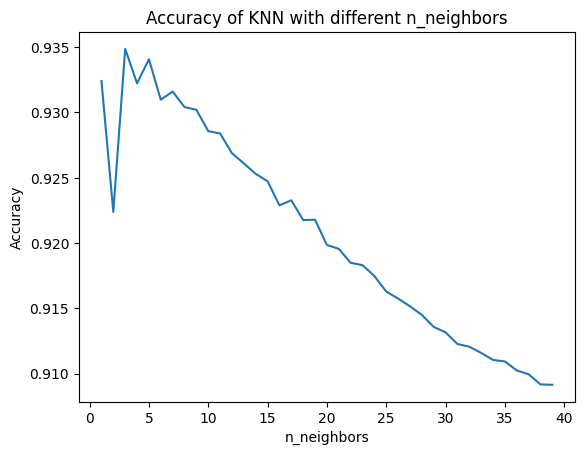

In [7]:
# k值的选择与准确率的关系
plo = plt.plot(range(1, 40), accuracy)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy of KNN with different n_neighbors')
plt.show()

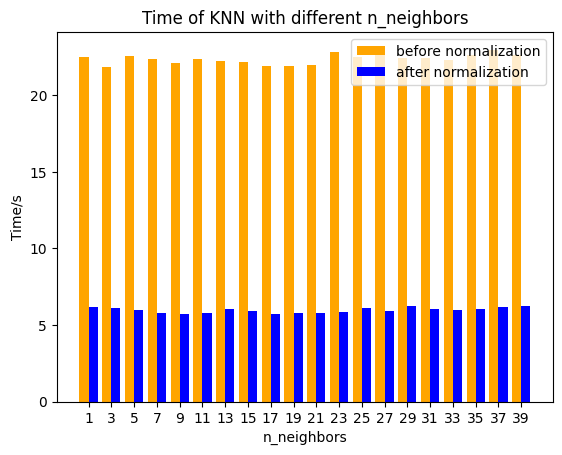

In [8]:
# 归一化前后的时间对比
plt.bar(range(1, 40,2), timelist_beforeNorm[::2], color='orange', label='time',width=-0.8, align='edge')
plt.bar(range(1, 40,2), timelist_afterNorm[::2], color='blue', label='time',width=0.8, align='edge')
plt.legend(['before normalization', 'after normalization'])
plt.title('Time of KNN with different n_neighbors')
plt.xticks(range(1, 40, 2))
plt.xlabel('n_neighbors')
plt.ylabel('Time/s')
plt.show()